In [1]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from prettytable import PrettyTable
from xgboost import XGBRegressor
import enum
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
#importing Pandas 
import pandas as pd
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


In [2]:
_PickleFilesFolder="pickle_files"
_PickleFile_Merged_Listing_NY="Merged_Listing_NY"
_PickleFile_Vectorized_Data="NY_Vectors"
_FolderPath="data"
_Pretty_table_logs = PrettyTable()
_Pretty_table_logs.field_names = ["Model Name", "MAE", "MSE","RMSE","R2"]

In [3]:
def getDataFrameFromNParray(fileName):
    arr =np.load( "./" + _FolderPath + "/" + _PickleFile_Merged_Listing_NY + "_" + fileName)['arr_0']
    return(pd.DataFrame(arr))

In [4]:
def getTrainingData(typeOfModel,sampleSize=-1):
    if (typeOfModel=="corr"):
        trainFile= "c_X_train_Final_1.npz"
        testFile="c_X_test_Final_1.npz"
    elif (typeOfModel=="pca"):
        trainFile= "X_train_Final_2.npz"
        testFile="X_test_Final_2.npz"
        
    ytrainFile="c_y_train.npz"
    ytestFile="c_y_test.npz"
    
    X_train=getDataFrameFromNParray(trainFile)
    X_test=getDataFrameFromNParray(testFile)
    y_train=getDataFrameFromNParray(ytrainFile)
    y_test=getDataFrameFromNParray(ytestFile)
    if sampleSize >0 :
        X_train=X_train.head(sampleSize)
        X_test=X_test.head(sampleSize)
        y_train=y_train.head(sampleSize)
        y_test=y_test.head(sampleSize)
    return X_train,X_test,y_train,y_test

# Custom Stacking Regressor

In [ ]:
'''
1) Split whole data into train and test(80-20)

2) Now, in the 80% train set, split the train set into D1 and D2.(50-50).

From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).

Now create 'k' models and train each of these models with each of these k samples.

3) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.

4) No-eate a new dataset, and for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.

5) Now, for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.




I hope you got it. For base models, you can consider any combination of models; you can take the DecisionTreeRegressor, LinearRegression, Lasso, Ridge, SVR, XGBoost, etc. And here, you can tune for the number of base models. The procedure mentioned above requires you to do custom coding. There are no library functions available for this as it is a custom model implementation.
'''

In [6]:
def defCreatSampleDataSets(df_source, sample_Size,row_count):
    sampleDataSets=[]
    for i in range(0, sample_Size):
        df =df_source.sample(n=row_count,random_state=10)
        df_y = df[cols-1]
        df_x = df.drop(df.columns[cols-1],axis=1)
        sampleDataSets.append([df_x,df_y])
    return sampleDataSets

In [72]:
# creating enumerations using class 
class eBaseModels(enum.Enum): 
    _Ridge = 0
    _Lasso = 1
    _ElasticNet=2
    _XGBRegressor=3
    _DecisionTreeRegressor=4
    _KNeighborsRegressor=5
    _AdaBoostRegressor=6
    _BaggingRegressor=7
    _RandomForestRegressor=8
    _ExtraTreesRegressor=9
    _SVR=10
    # create a list of base-models

def get_base_model(ebaseModel):
    ebaseModel=eBaseModels(ebaseModel)
    if ebaseModel== eBaseModels._Ridge:
        createlogs("creating ridge model")
        return Ridge(alpha=1001)
    elif ebaseModel== eBaseModels._Lasso:
        createlogs("creating lasso model")
        return Lasso(alpha=0.06)
    elif ebaseModel== eBaseModels._ElasticNet:
        createlogs("creating Elasticnet model")
        return ElasticNet(alpha=0.5)
    elif ebaseModel== eBaseModels._XGBRegressor:
        createlogs("creating XGB Model")
        return XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=0.7, gamma=0, 
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.05, max_delta_step=0, max_depth=7,
                 min_child_weight=4,
                 n_estimators=500, n_jobs=-1, 
                 objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, subsample=0.7, tree_method='exact',
                 validate_parameters=1, verbosity=None)  
    elif ebaseModel== eBaseModels._DecisionTreeRegressor:
        createlogs("creating DecisionTreeRegressor Model")
        return DecisionTreeRegressor()
    elif ebaseModel== eBaseModels._KNeighborsRegressor:
        createlogs("creating KNeighborsRegressor Model")
        return KNeighborsRegressor(n_jobs=-1)
    elif ebaseModel== eBaseModels._AdaBoostRegressor:
        createlogs("creating XGB Model")
        return AdaBoostRegressor()
    elif ebaseModel== eBaseModels._BaggingRegressor:
        createlogs("creating BaggingRegressor Model")
        return BaggingRegressor(n_estimators=10,n_jobs=-1)
    elif ebaseModel== eBaseModels._RandomForestRegressor:
        createlogs("creating RandomForestRegressor Model")
        return RandomForestRegressor(n_estimators=10,n_jobs=-1)
    elif ebaseModel==eBaseModels._ExtraTreesRegressor:
        createlogs("creating ExtraTreesRegressor Model")
        return ExtraTreesRegressor(n_estimators=10,n_jobs=-1)
    elif ebaseModel==eBaseModels._SVR:
        createlogs("creating SVR Model")
        return SVR(kernel='rbf',C=1,epsilon=0.1 )

In [73]:

def trainModelsFromSamples(samples):
    sample_counter=0
    sample_trained_Models_and_predictions=[]
    logMessage="Generating Models : " + str(len(samples)) + " out of " +  str (base_models_count) + " For Sample : " + str(len(samples))
    createlogs(logMessage)
    for sample in samples:
        createlogs("Prcessing for Sample Number : " + str(sample_counter +1 ))
        sample_x= sample[0]
        sample_y=sample[1]
        if sample_counter > base_models_count-1:
            sample_counter=0
        model= get_base_model(sample_counter)
        model.fit(sample_x,sample_y)
        predictions=model.predict(d2_x)
        rms = sqrt(mean_squared_error(d2_y, predictions))
        r2_s=r2_score(d2_y, predictions)
        createlogs("Model Trained")
        createlogs("RMSE : " + str(r2_s))
        createlogs("R-Square : " + str(rms ))
        sample_trained_Models_and_predictions.append([model,predictions,rms])
        sample_counter=sample_counter+1
    return sample_trained_Models_and_predictions

In [74]:
_PrintMessageStatments=True
def createlogs(message):
    if _PrintMessageStatments==True:
        print(message) 
    #code to add for log messages

In [75]:
X_train,X_test,y_train,y_test=getTrainingData("pca")

In [76]:
print("X Train", X_train.shape)
print("X Test", X_test.shape)
print("Y Train", y_train.shape)
print("Y Test", y_test.shape)

X Train (25830, 2500)
X Test (11070, 2500)
Y Train (25830, 1)
Y Test (11070, 1)


In [77]:
df_X_tr =pd.concat([X_train,y_train],axis=1,ignore_index=True)
df_X_te=pd.concat([X_test,y_test],axis=1,ignore_index=True)

In [78]:
print(df_X_tr.shape)
print(df_X_te.shape)

(25830, 2501)
(11070, 2501)


In [79]:
#Split Data set into 50-50

In [80]:
total_records= df_X_tr.shape[0]
split_ratio= int(total_records/2)
d1= df_X_tr.head(split_ratio)
d2=df_X_tr.tail(split_ratio)
print("d1 : ",d1.shape)
print("d2 : " ,d2.shape)


d1 :  (12915, 2501)
d2 :  (12915, 2501)


In [81]:
cols=len(d1.columns)
d2_y=d2[cols-1]
d2_x = d2.drop(d2.columns[cols-1],axis=1)
print("d2_x : ",d2_x.shape)
print("d2_y : " ,d2_y.shape)

d2_x :  (12915, 2500)
d2_y :  (12915,)


In [82]:
metamodel=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=0.7, gamma=0, 
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.05, max_delta_step=0, max_depth=7,
                 min_child_weight=4,
                 n_estimators=500, n_jobs=-1, 
                 objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, subsample=0.7, tree_method='exact',
                 validate_parameters=1, verbosity=None) 

In [83]:
base_models_count=len(eBaseModels)
kvalues=[2,3,5,8,9,10,12,15,20,30,40]
print("Total base models: ",base_models_count )

Total base models:  11


In [ ]:
result=[]
for k in kvalues:
    print("="*50)
    print("K = ",k)
    print("="*50)
    k_samples=defCreatSampleDataSets(d1,k,1000)
    k_sample_models_predctions= trainModelsFromSamples(k_samples)
    k_sample_predictions=[]
    for pred in k_sample_models_predctions:
        y_hat=pred[1]
        k_sample_predictions.append(y_hat)
    k_df_sample_predc= pd.DataFrame(k_sample_predictions).T
    
    metamodel.fit(k_df_sample_predc,d2_y)
    
    k_test_predictions=[]
    for trainedModels in k_sample_models_predctions:
        model=trainedModels[0]
        y_hat=model.predict(X_test)                                            
        k_test_predictions.append(y_hat)
    k_df_test_predictions= pd.DataFrame(k_test_predictions).T
    
    k_final_pred=metamodel.predict(k_df_test_predictions)
    k_rms_final = sqrt(mean_squared_error(y_test, k_final_pred))
    k_r2_final=r2_score(y_test, k_final_pred)
    result.append([k,k_rms_final,k_r2_final])

In [98]:
df_result=pd.DataFrame(result)
 
df_result.columns =['K-Sample', 'RMSE', 'R-Square'] 

In [99]:

df_result


,K-Sample,RMSE,R-Square
0,2,81.557297,0.879970
1,3,83.387821,0.874521
2,5,77.148074,0.892597
3,8,76.018039,0.895721
4,9,79.316984,0.886473
5,10,73.591594,0.902271
6,12,76.528692,0.894315
7,15,71.718755,0.907182
8,20,78.433924,0.888987
9,30,72.128067,0.906120


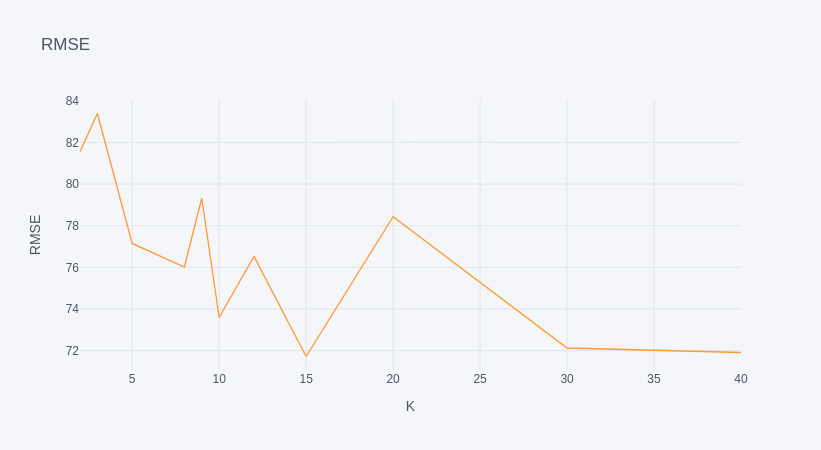

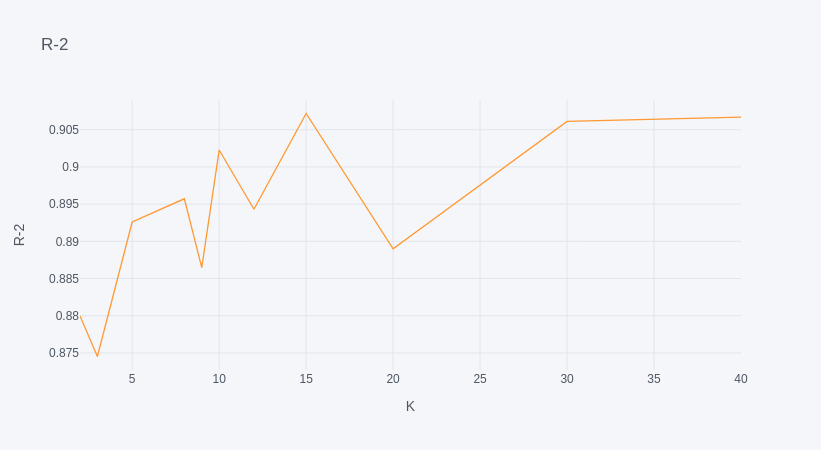

In [104]:
df_result.iplot( x ='K-Sample', y ='RMSE',title="RMSE",xTitle="K",yTitle="RMSE") 
df_result.iplot( x ='K-Sample', y ='R-Square',title="R-2",xTitle="K",yTitle="R-2") 

In [ ]:
result=[]
for k in kvalues:
    print("="*50)
    print("K = ",k)
    print("="*50)
    k_samples=defCreatSampleDataSets(d1,k,5000)
    k_sample_models_predctions= trainModelsFromSamples(k_samples)
    k_sample_predictions=[]
    for pred in k_sample_models_predctions:
        y_hat=pred[1]
        k_sample_predictions.append(y_hat)
    k_df_sample_predc= pd.DataFrame(k_sample_predictions).T
    
    metamodel.fit(k_df_sample_predc,d2_y)
    
    k_test_predictions=[]
    for trainedModels in k_sample_models_predctions:
        model=trainedModels[0]
        y_hat=model.predict(X_test)                                            
        k_test_predictions.append(y_hat)
    k_df_test_predictions= pd.DataFrame(k_test_predictions).T
    
    k_final_pred=metamodel.predict(k_df_test_predictions)
    k_rms_final = sqrt(mean_squared_error(y_test, k_final_pred))
    k_r2_final=r2_score(y_test, k_final_pred)
    result.append([k,k_rms_final,k_r2_final])

In [111]:
df_result=pd.DataFrame(result)
 
df_result.columns =['K-Sample', 'RMSE', 'R-Square'] 
df_result

,K-Sample,RMSE,R-Square
0,2,94.837710,0.837697
1,3,92.400949,0.845930
2,5,81.968576,0.878756
3,8,72.674783,0.904691
4,9,80.968548,0.881696
5,10,82.438853,0.877361
6,12,72.379424,0.905464
7,15,74.105195,0.900902
8,20,76.032361,0.895681
9,30,75.794786,0.896332


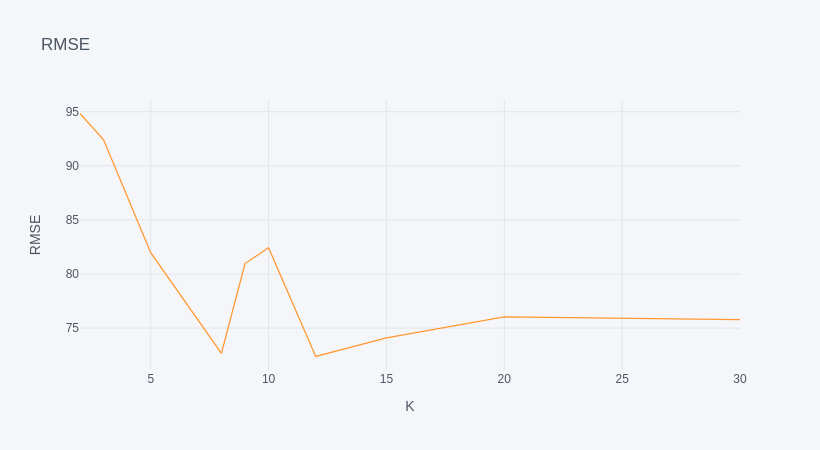

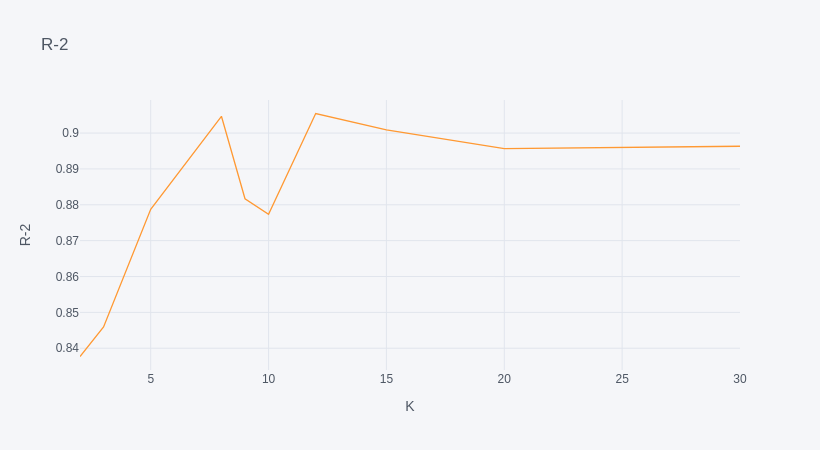

In [112]:
df_result.iplot( x ='K-Sample', y ='RMSE',title="RMSE",xTitle="K",yTitle="RMSE") 
df_result.iplot( x ='K-Sample', y ='R-Square',title="R-2",xTitle="K",yTitle="R-2") 

In [ ]:
result=[]
for k in kvalues:
    print("="*50)
    print("K = ",k)
    print("="*50)
    k_samples=defCreatSampleDataSets(d1,k,3000)
    k_sample_models_predctions= trainModelsFromSamples(k_samples)
    k_sample_predictions=[]
    for pred in k_sample_models_predctions:
        y_hat=pred[1]
        k_sample_predictions.append(y_hat)
    k_df_sample_predc= pd.DataFrame(k_sample_predictions).T
    
    metamodel.fit(k_df_sample_predc,d2_y)
    
    k_test_predictions=[]
    for trainedModels in k_sample_models_predctions:
        model=trainedModels[0]
        y_hat=model.predict(X_test)                                            
        k_test_predictions.append(y_hat)
    k_df_test_predictions= pd.DataFrame(k_test_predictions).T
    
    k_final_pred=metamodel.predict(k_df_test_predictions)
    k_rms_final = sqrt(mean_squared_error(y_test, k_final_pred))
    k_r2_final=r2_score(y_test, k_final_pred)
    result.append([k,k_rms_final,k_r2_final])

In [108]:
df_result=pd.DataFrame(result)
 
df_result.columns =['K-Sample', 'RMSE', 'R-Square'] 
df_result

,K-Sample,RMSE,R-Square
0,2,74.370717,0.900191
1,3,73.369962,0.902859
2,5,73.245073,0.903190
3,8,83.715158,0.873534
4,9,77.517516,0.891566
5,10,87.975729,0.860334
6,12,68.175959,0.916126
7,15,77.588160,0.891368
8,20,81.872737,0.879039
9,30,80.856995,0.882022


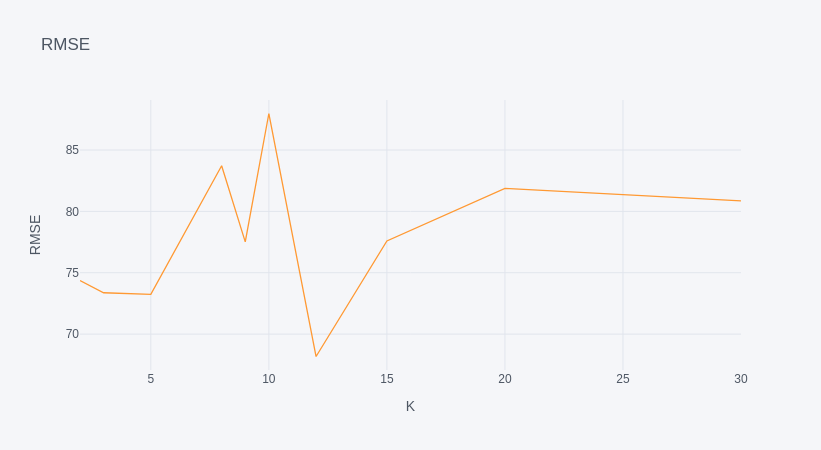

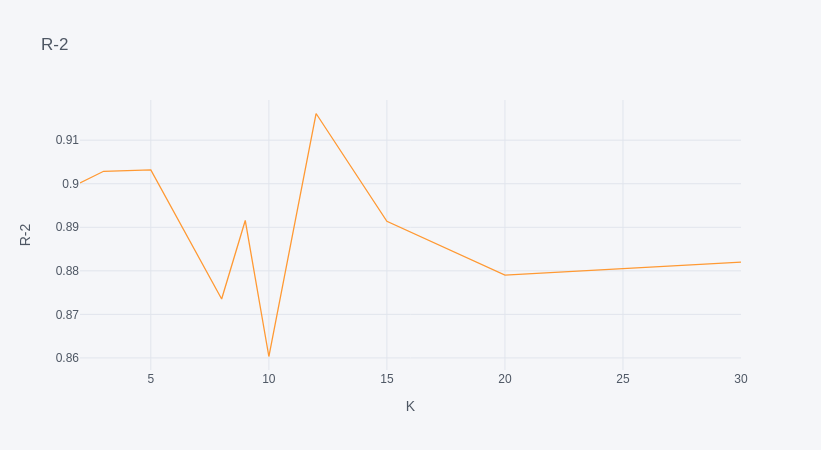

In [109]:
df_result.iplot( x ='K-Sample', y ='RMSE',title="RMSE",xTitle="K",yTitle="RMSE") 
df_result.iplot( x ='K-Sample', y ='R-Square',title="R-2",xTitle="K",yTitle="R-2") 

In [ ]:
result=[]
for k in kvalues:
    print("="*50)
    print("K = ",k)
    print("="*50)
    k_samples=defCreatSampleDataSets(d1,k,10000)
    k_sample_models_predctions= trainModelsFromSamples(k_samples)
    k_sample_predictions=[]
    for pred in k_sample_models_predctions:
        y_hat=pred[1]
        k_sample_predictions.append(y_hat)
    k_df_sample_predc= pd.DataFrame(k_sample_predictions).T
    
    metamodel.fit(k_df_sample_predc,d2_y)
    
    k_test_predictions=[]
    for trainedModels in k_sample_models_predctions:
        model=trainedModels[0]
        y_hat=model.predict(X_test)                                            
        k_test_predictions.append(y_hat)
    k_df_test_predictions= pd.DataFrame(k_test_predictions).T
    
    k_final_pred=metamodel.predict(k_df_test_predictions)
    k_rms_final = sqrt(mean_squared_error(y_test, k_final_pred))
    k_r2_final=r2_score(y_test, k_final_pred)
    result.append([k,k_rms_final,k_r2_final])

In [88]:
df_result=pd.DataFrame(result)
 
df_result.columns =['K-Sample', 'RMSE', 'R-Square'] 

In [89]:
df_result

,K-Sample,RMSE,R-Square
0,2,93.685653,0.841616
1,3,91.779701,0.847995
2,5,83.275136,0.874860
3,8,68.004069,0.916548
4,9,79.998363,0.884514
5,10,86.046041,0.866394
6,12,77.549743,0.891476
7,15,70.621450,0.910001
8,20,71.222143,0.908463


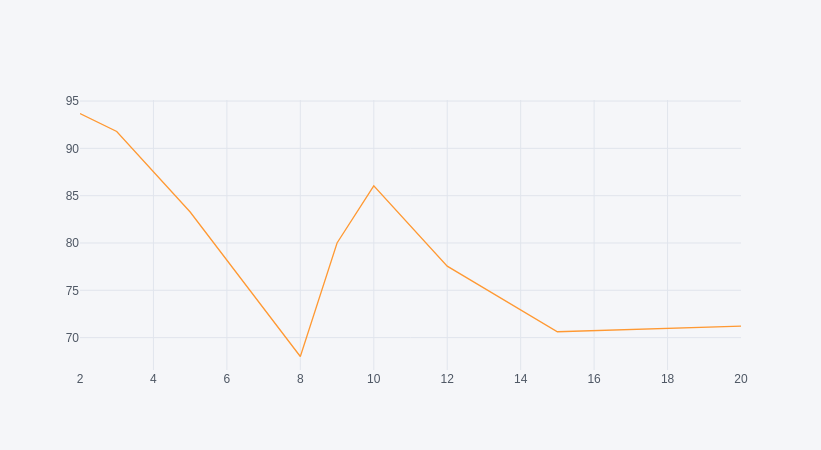

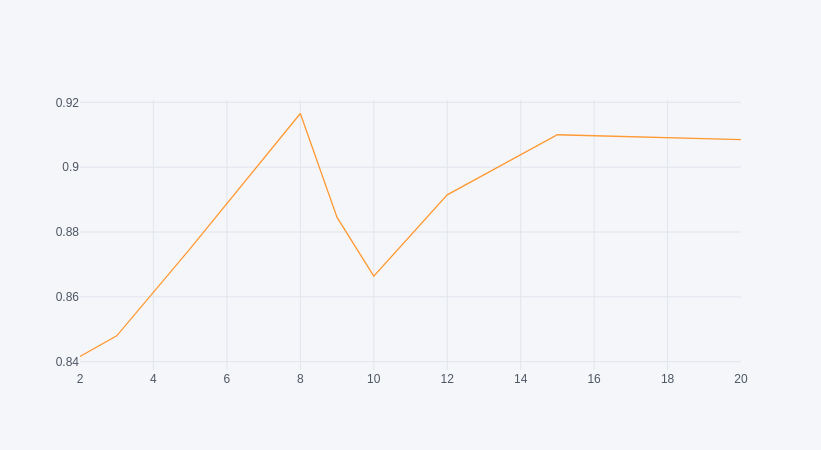

In [93]:

df_result.iplot( x ='K-Sample', y ='RMSE') 
df_result.iplot( x ='K-Sample', y ='R-Square') 